Bahdanau Attention

In [ ]:
# Standard Bahdanau Attention
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, decoder_layer):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.decoder_layer = decoder_layer
        self.softmax = nn.Softmax(dim=0)
        self.proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh = nn.Tanh()
        self.hidden_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.encoder_output_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    # hidden: b, f  encoder_output: t, b, f  enc_len: numpy
    def forward(self, hidden, encoder_output, enc_len, prev_attention):
        # prev_attention will not be used aqui
        encoder_output = encoder_output.transpose(0, 1) # b, t, f
        attn_energy = self.score(hidden, encoder_output) # b, t

        attn_weight = torch.zeros(attn_energy.shape)
        for i, le in enumerate(enc_len):
            attn_weight[i, :le] = self.softmax(attn_energy[i, :le])
        return attn_weight.unsqueeze(2)

    # hidden: 1, batch, features
    # encoder_output: batch, time_step, features
    def score(self, hidden, encoder_output):
        hidden = hidden.permute(1, 2, 0) # batch, features, layers
        addMask = torch.FloatTensor([1/self.decoder_layer] * self.decoder_layer).view(1, self.decoder_layer, 1)
        addMask = torch.cat([addMask] * hidden.shape[0], dim=0)
        hidden = torch.bmm(hidden, addMask) # batch, feature, 1
        hidden = hidden.permute(0, 2, 1) # batch, 1, features
        hidden_attn = self.hidden_proj(hidden) # b, 1, f
        #hidden_attn = hidden_attn.permute(1, 0, 2) # batch, 1, features
        encoder_output_attn = self.encoder_output_proj(encoder_output)
        res_attn = self.tanh(encoder_output_attn + hidden_attn) # b, t, f
        #res_attn = self.tanh(encoder_output + hidden_attn) # b, t, f
        out_attn = self.out(res_attn) # b, t, 1
        out_attn = out_attn.squeeze(2) # b, t
        return out_attn

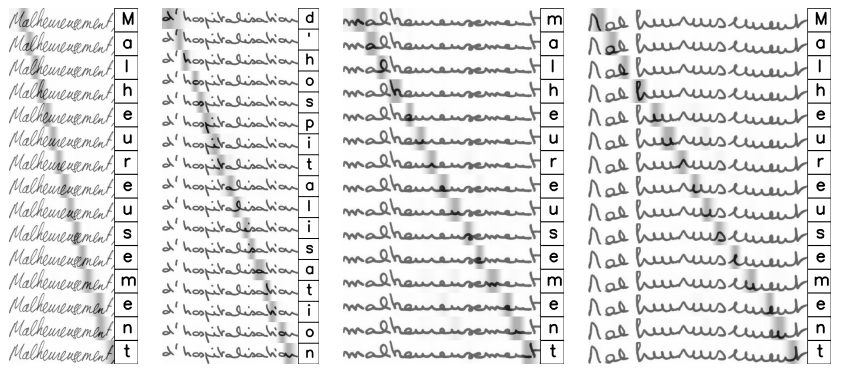

In [1]:
from PIL import Image
attn = Image.open('attn.png').convert('RGB')
attn

Reference code: https://github.com/omni-us/research-seq2seq-HTR/blob/master/models/attention.py 